# Modelos estadísticos y de *Machine Learning*
Cuaderno generado automáticamente – 2025-04-26T14:37:33.041185 UTC

Este notebook contiene ejemplos **reproducibles** de:
1. Regresión logística (GLM paramétrico)
2. Regresión logística bayesiana (modelo paramétrico bayesiano)
3. K-means (modelo no paramétrico, clustering)
4. Kernel Density Estimate (modelo no paramétrico, estimación de densidad)
5. Random Forest (modelo no paramétrico supervisado)

Cada sección incluye carga de datos, ajuste del modelo, evaluación e interpretación básica. Funciona en Google Colab o Jupyter con Python ≥3.9.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
np.random.seed(42)
sns.set_style('whitegrid')

## 1. Regresión logística (GLM paramétrico)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [12]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [13]:
# Dataset de cáncer de mama de scikit‑learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

data = load_breast_cancer(as_frame=True)
df = data.frame
X = sm.add_constant(df[data.feature_names])  # Covariables
y = df['target'] # Indicadora de la existencia de cancer 

# dividimos para evaluación rápida
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
res = model.fit()
print(res.summary())

# métrica de desempeño
from sklearn.metrics import accuracy_score
y_pred = (res.predict(X_test) > 0.5).astype(int)
print('Accuracy test:', accuracy_score(y_test, y_pred))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  426
Model:                            GLM   Df Residuals:                      395
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 03 May 2025   Deviance:                       552.62
Time:                        11:56:25   Pearson chi2:                 2.70e+16
No. Iterations:                    16   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

c:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


## 2. Regresión logística bayesiana (PyMC)

In [8]:
# archivo: logistic_pymc_v4.py
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Datos
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Selección y estandarización
cols = data.feature_names[:5]
X = df[cols].values
y = df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo en PyMC 4
with pm.Model() as logistic_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    coefs = pm.Normal("coefs", mu=0, sigma=10, shape=X.shape[1])

    logits = intercept + pm.math.dot(X_scaled, coefs)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)
    az.plot_trace(trace, var_names=["Intercept", "coefs"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, coefs]


Output()

ValueError: Not enough samples to build a trace.

# Funcional

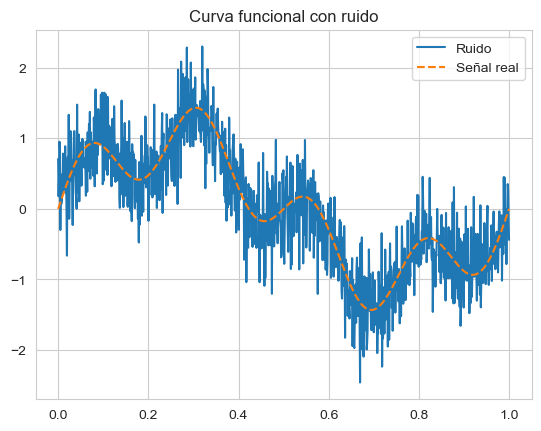

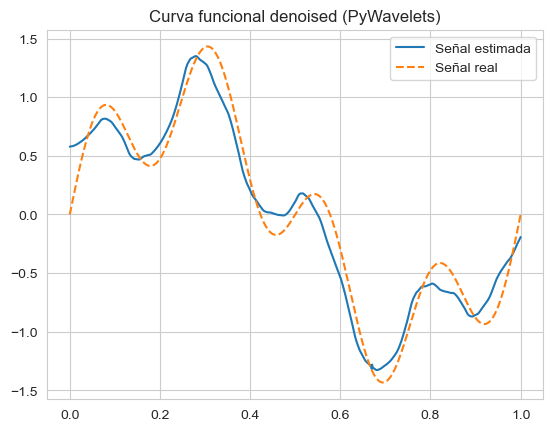

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
# Garantizar reproducibilidad
np.random.seed(0)

# Generar curva funcional suave
n = 1024
x = np.linspace(0, 1, n)
signal_clean = np.sin(2 * np.pi * x) + 0.5 * np.sin(8 * np.pi * x)

# Añadir ruido gaussiano
noise = np.random.normal(scale=0.4, size=n)
signal_noisy = signal_clean + noise

# Intentamos importar PyWavelets; si no está, lo instalamos

# Descomposición multiresolución
wavelet = 'db4'
level = pywt.dwt_max_level(len(signal_noisy), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(signal_noisy, wavelet, level=level)

# Umbral universal (VisuShrink)
sigma_est = np.median(np.abs(coeffs[-1])) / 0.6745
uthresh = sigma_est * np.sqrt(2 * np.log(len(signal_noisy)))

coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') if i > 0 else c
                 for i, c in enumerate(coeffs)]

signal_denoised = pywt.waverec(coeffs_thresh, wavelet)

# Cortar posible padding
signal_denoised = signal_denoised[:n]

# === Gráficos ===
plt.figure()
plt.plot(x, signal_noisy, label="Ruido")
plt.plot(x, signal_clean, label="Señal real", linestyle='--')
plt.title("Curva funcional con ruido")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, signal_denoised, label="Señal estimada")
plt.plot(x, signal_clean, label="Señal real", linestyle='--')
plt.title("Curva funcional denoised (PyWavelets)")
plt.legend()
plt.show()




## 4. Estimación de densidad Kernel (KDE)

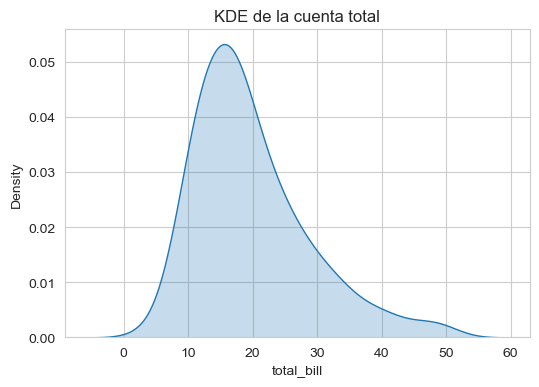

In [4]:
tips = sns.load_dataset('tips')
plt.figure(figsize=(6,4))
sns.kdeplot(tips['total_bill'], fill=True)
plt.title('KDE de la cuenta total');

## 3. K-means (clustering no paramétrico)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
iris = sns.load_dataset('iris')
X_iris = StandardScaler().fit_transform(iris.drop(columns='species'))
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_iris)
iris['cluster'] = kmeans.labels_
sns.pairplot(iris, hue='cluster', diag_kind='hist');

## 5. Random Forest (supervisado no paramétrico)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = df[data.feature_names]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print('Accuracy test:', rf.score(X_test, y_test))

# Importancia de variables
imp = pd.Series(rf.feature_importances_, index=data.feature_names).sort_values(ascending=False)[:10]
imp.plot.bar(); plt.ylabel('Importancia'); plt.title('Top 10 variables importantes');